# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


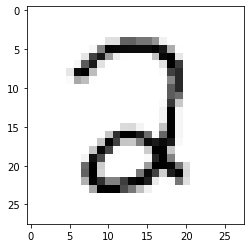

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2507
Training Accuracy: 0.4757, Testing Accuracy: 0.4597



Epoch 10, Loss 0.2411
Training Accuracy: 0.7762, Testing Accuracy: 0.7898



Epoch 20, Loss 0.2066
Training Accuracy: 0.8655, Testing Accuracy: 0.8826



Epoch 30, Loss 0.1182
Training Accuracy: 0.9109, Testing Accuracy: 0.9294



Epoch 40, Loss 0.0683
Training Accuracy: 0.9317, Testing Accuracy: 0.9410



Epoch 50, Loss 0.0513
Training Accuracy: 0.9454, Testing Accuracy: 0.9516



Epoch 60, Loss 0.0431
Training Accuracy: 0.9507, Testing Accuracy: 0.9577



Epoch 70, Loss 0.0385
Training Accuracy: 0.9553, Testing Accuracy: 0.9632



Epoch 80, Loss 0.0354
Training Accuracy: 0.9586, Testing Accuracy: 0.9652



Epoch 90, Loss 0.0333
Training Accuracy: 0.9609, Testing Accuracy: 0.9652



Epoch 100, Loss 0.0316
Training Accuracy: 0.9629, Testing Accuracy: 0.9657



Epoch 110, Loss 0.0302
Training Accuracy: 0.9645, Testing Accuracy: 0.9662



Epoch 120, Loss 0.0291
Training Accuracy: 0.9660, Testing Accuracy: 0.9672



Epoch 130, Loss 0.0281
Training Accuracy: 0.9670, Testing Accuracy: 0.9682



Epoch 140, Loss 0.0273
Training Accuracy: 0.9682, Testing Accuracy: 0.9682



Epoch 150, Loss 0.0265
Training Accuracy: 0.9689, Testing Accuracy: 0.9682



Epoch 160, Loss 0.0258
Training Accuracy: 0.9693, Testing Accuracy: 0.9693



Epoch 170, Loss 0.0252
Training Accuracy: 0.9703, Testing Accuracy: 0.9698



Epoch 180, Loss 0.0246
Training Accuracy: 0.9711, Testing Accuracy: 0.9698



Epoch 190, Loss 0.0241
Training Accuracy: 0.9715, Testing Accuracy: 0.9698



Epoch 200, Loss 0.0236
Training Accuracy: 0.9726, Testing Accuracy: 0.9693



Epoch 210, Loss 0.0231
Training Accuracy: 0.9732, Testing Accuracy: 0.9698



Epoch 220, Loss 0.0227
Training Accuracy: 0.9736, Testing Accuracy: 0.9693



Epoch 230, Loss 0.0223
Training Accuracy: 0.9745, Testing Accuracy: 0.9698



Epoch 240, Loss 0.0219
Training Accuracy: 0.9750, Testing Accuracy: 0.9698



0.03213298249269386

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2307
Training Accuracy: 0.7555, Testing Accuracy: 0.7767



Epoch 10, Loss 0.1006
Training Accuracy: 0.9127, Testing Accuracy: 0.9249



Epoch 20, Loss 0.0778
Training Accuracy: 0.9293, Testing Accuracy: 0.9385



Epoch 30, Loss 0.0673
Training Accuracy: 0.9372, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0609
Training Accuracy: 0.9426, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0565
Training Accuracy: 0.9456, Testing Accuracy: 0.9541



Epoch 60, Loss 0.0533
Training Accuracy: 0.9494, Testing Accuracy: 0.9551



Epoch 70, Loss 0.0508
Training Accuracy: 0.9513, Testing Accuracy: 0.9572



Epoch 80, Loss 0.0488
Training Accuracy: 0.9518, Testing Accuracy: 0.9587



Epoch 90, Loss 0.0471
Training Accuracy: 0.9531, Testing Accuracy: 0.9597



Epoch 100, Loss 0.0457
Training Accuracy: 0.9535, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0445
Training Accuracy: 0.9543, Testing Accuracy: 0.9622



Epoch 120, Loss 0.0435
Training Accuracy: 0.9553, Testing Accuracy: 0.9617



Epoch 130, Loss 0.0425
Training Accuracy: 0.9559, Testing Accuracy: 0.9627



Epoch 140, Loss 0.0417
Training Accuracy: 0.9564, Testing Accuracy: 0.9632



Epoch 150, Loss 0.041
Training Accuracy: 0.9569, Testing Accuracy: 0.9642



Epoch 160, Loss 0.0403
Training Accuracy: 0.9578, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0397
Training Accuracy: 0.9583, Testing Accuracy: 0.9652



Epoch 180, Loss 0.0392
Training Accuracy: 0.9592, Testing Accuracy: 0.9652



Epoch 190, Loss 0.0387
Training Accuracy: 0.9596, Testing Accuracy: 0.9657



Epoch 200, Loss 0.0382
Training Accuracy: 0.9601, Testing Accuracy: 0.9657



Epoch 210, Loss 0.0378
Training Accuracy: 0.9607, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0373
Training Accuracy: 0.9609, Testing Accuracy: 0.9667



Epoch 230, Loss 0.037
Training Accuracy: 0.9613, Testing Accuracy: 0.9672



Epoch 240, Loss 0.0366
Training Accuracy: 0.9619, Testing Accuracy: 0.9672



0.04068758227243192

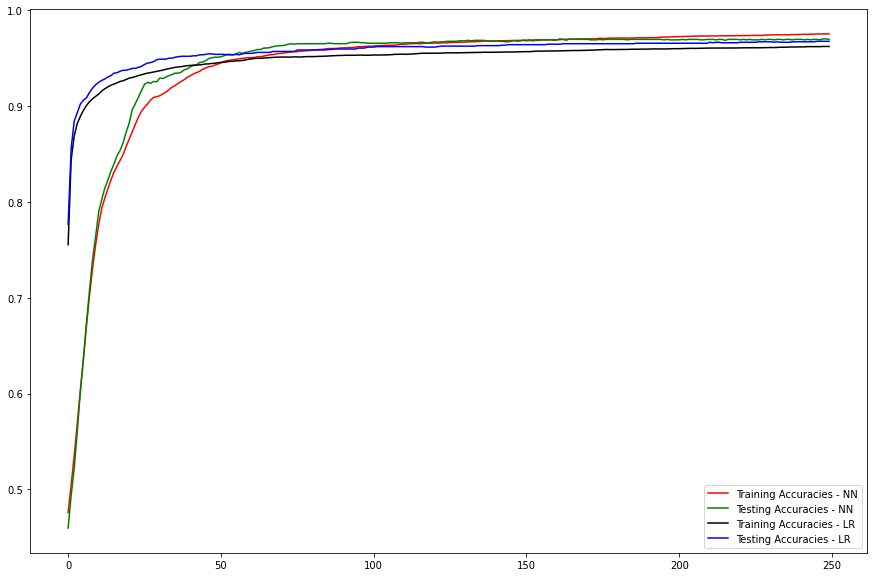

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

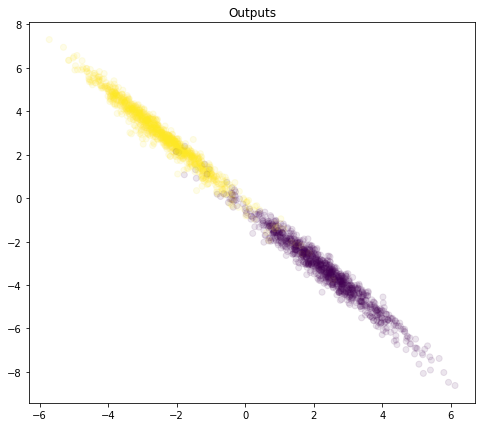

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

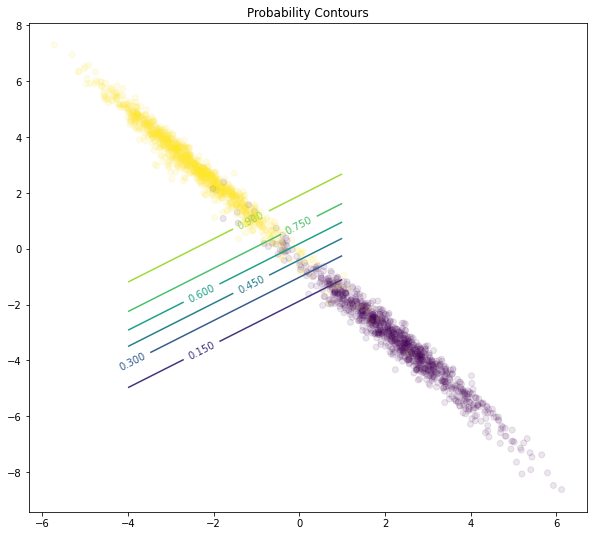

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );